In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from datetime import datetime

from eol_utils import pre_process, cleanse_title, show_metrics
from eol_config import eol_path, pickle_path, train_path, train_file, ngram_range


#### import data and pre process ####

In [2]:
df_train = pd.read_excel(io=train_path + train_file, engine='openpyxl')
df_train.shape

(1526, 6)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   plugin_id    1526 non-null   object
 1   scanner      1526 non-null   object
 2   title        1516 non-null   object
 3   description  1518 non-null   object
 4   plugin_type  8 non-null      object
 5   is_eol       1526 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 61.2+ KB


In [4]:
df_train['title'] = df_train['title'].replace(np.nan, '')
df_train['description'] = df_train['description'].replace(np.nan, '')
df_train['clean_desc'] = df_train['title'].values + ' ' + df_train['description'].values
df_train['clean_desc'] = df_train['clean_desc'].apply(pre_process)

In [5]:
bf_dedup_len = df_train.shape[0]
df_train.drop_duplicates(subset='plugin_id', inplace=True)
if df_train.shape[0] < bf_dedup_len:
    print(f'Removed {bf_dedup_len - df_train.shape[0]} duplicates from train data')
df_train.fillna('', inplace=True)
df_train['is_eol'] = df_train['is_eol'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)   #  True if x == 'True' else x
print('is_eol column  frequency distribution')
print(df_train.is_eol.value_counts())

Removed 4 duplicates from train data
is_eol column  frequency distribution
True     837
False    685
Name: is_eol, dtype: int64


In [7]:
df_train[df_train.is_eol == False]

,plugin_id,scanner,title,description,plugin_type,is_eol,clean_desc
0,QUALYS100003,QUALYS,Microsoft Internet Explorer Cumulative Securit...,the cumulative security update for microsoft i...,,False,vendor internet explorer cumulative security u...
1,QUALYS100031,QUALYS,Microsoft Internet Explorer window() Code Exec...,a critical vulnerability has been identified i...,,False,vendor internet explorer code execution vulner...
2,QUALYS100046,QUALYS,Microsoft Internet Explorer Cumulative Securit...,multiple vulnerabilities exist in internet exp...,,False,vendor internet explorer cumulative security u...
3,QUALYS100047,QUALYS,Cumulative Security Update for Internet Explor...,multiple vulnerabilities exist in internet exp...,,False,cumulative security update internet explorer m...
4,QUALYS100050,QUALYS,Cumulative Security Update for Internet Explor...,a remote code execution vulnerability exists i...,,False,cumulative security update internet explorer m...
...,...,...,...,...,...,...,...
1454,SERVICEPACK-RIGHTS-MGMT-SERVICES-CLIENT-SP2-IT...,NEXPOSE,Windows Rights Management Services Client with...,\n \n<p>Rights Management Services (RMS) cl...,,False,window right management service client service...
1455,9B329198F37D3100957D95C62B0391F2585D6A30398EA0...,NESSUS,MBSS-OS-RHEL7-057a - 2.2.1.1 (L1) Ensure time ...,"""MBSS-OS-RHEL7-057a - 2.2.1.1 (L1) Ensure time...",,False,mb o rhel l ensure time synchronization use ma...
1456,A46995E4E058C68B706D9AA9A53C990148ACE6B5319A5F...,NESSUS,NTP is not installed,"""NTP is not installed"" : </br></br>The followi...",,False,ntp not instal ntp not instal follow clause no...
1524,78008,NESSUS,RHEL 4 / 5 / 6 : JBoss EAP (RHSA-2014:1321),Updated packages for Red Hat JBoss Enterprise ...,,False,rhel jboss eap rhsa update package red hat jbo...


#### split ####

In [6]:
log = print

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train['clean_desc'], df_train['is_eol'], test_size = 0.2, shuffle=True
)
log(f'df_train splitted into training set [{len(X_train)}] and validation set [{len(X_val)}]')

df_train splitted into training set [1217] and validation set [305]


#### vectorization ####

In [9]:
# bow_vectorizer = CountVectorizer(ngram_range=ngram_range)
# X_train_vectors_bow = bow_vectorizer.fit_transform(X_train)
# X_val_vectors_bow = bow_vectorizer.transform(X_val)
# bow_features = bow_vectorizer.get_feature_names_out()
# log(f'Bag of Words Features: {len(bow_features)}')

bow_vectorizer = CountVectorizer(ngram_range=ngram_range)
df_train_vectors_bow = bow_vectorizer.fit_transform(df_train['clean_desc'])
# X_val_vectors_bow = bow_vectorizer.transform(X_val)
bow_features = bow_vectorizer.get_feature_names_out()
log(f'Bag of Words Features: {len(bow_features)}')

Bag of Words Features: 39962


In [10]:
X_train

38    cisco prime data center network manager rmi re...
63    osticket provide functionality upload html fil...
35    cross site referrer leakage usage of no referr...
51            eol obsolete operate system window detect
44    target run version of no longer support develo...
39    apsb security update available adobe reader ac...
27    rhel thunderbird rhsa update thunderbird avail...
57    rhsa evolution data server security update evo...
33    zoho manageengine adselfservice plus cve rest ...
21    internet explorer code execution vulnerability...
62    bugzilla x x x x x x inbound proxy option enab...
19               request officially stop support python
24    cumulative security update internet explorer m...
46                        eol obsolete operating system
8     obsolete version detect version reach end of t...
15    extend update support eol notice theextended u...
47                        eol obsolete operating system
68    ibm atlas ediscovery process management ea

In [11]:
X_train.index

Int64Index([ 9, 27, 36, 12, 49, 65, 15, 54, 14, 53, 20, 64, 47, 17, 21, 18,  0,
            11, 48, 62, 46, 50,  7, 10, 16, 43, 13, 35, 29,  4, 24, 69, 40, 56,
            63, 55, 37, 57, 58,  1, 41, 26,  5, 38, 22,  3, 32, 23, 61,  6, 44,
            42, 25, 33, 60,  8],
           dtype='int64')

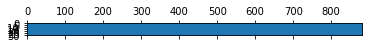

In [19]:
plt.spy(X_train_vectors_bow)

In [40]:
print(df_train_vectors_bow)

  (0, 66)	1
  (0, 194)	1
  (0, 307)	1
  (0, 262)	1
  (0, 249)	1
  (0, 52)	1
  (0, 205)	1
  (0, 130)	1
  (0, 312)	1
  (0, 39)	1
  (0, 167)	1
  (0, 95)	1
  (0, 20)	1
  (0, 80)	1
  (0, 58)	1
  (0, 300)	1
  (0, 362)	1
  (0, 336)	1
  (0, 311)	1
  (1, 167)	1
  (1, 95)	1
  (1, 20)	1
  (1, 80)	1
  (1, 58)	1
  (1, 300)	1
  :	:
  (43, 390)	1
  (43, 154)	1
  (43, 209)	1
  (43, 303)	1
  (43, 116)	1
  (43, 119)	1
  (43, 382)	1
  (43, 136)	1
  (43, 148)	1
  (43, 118)	1
  (43, 340)	1
  (43, 186)	1
  (43, 395)	1
  (44, 198)	1
  (44, 171)	1
  (44, 381)	1
  (44, 207)	1
  (44, 390)	1
  (44, 154)	1
  (44, 136)	1
  (44, 148)	1
  (44, 118)	1
  (44, 340)	1
  (44, 117)	1
  (44, 288)	1


##### analysis of vectors #####

In [10]:
from nltk import ngrams
true_vectors, false_vectors, not_trained_vectors = set(), set(), set()
for idx, row in df_train.iterrows():
    # features = row['clean_desc'].split()
    features = ngrams(row['clean_desc'].split(' '), n=3)
    if row['is_eol'] == True:
        true_vectors.update(features)
    else:
        false_vectors.update(features)
both_vectors = true_vectors.intersection(false_vectors)
true_only_vectors = true_vectors - both_vectors
false_only_vectors = false_vectors - both_vectors
len(bow_features), len(true_vectors), len(false_vectors), len(both_vectors), len(true_only_vectors), len(false_only_vectors)


(39962, 26248, 15397, 650, 25598, 14747)

In [11]:
true_only_list, false_only_list, both_list, others_list = [], [], [], []
for idx, row in df_train.iterrows():
    # features = row['clean_desc'].split()
    features = ngrams(row['clean_desc'].split(' '), n=3)
    for word in features:
        if word in true_only_vectors:
            true_only_list.append(word)
        elif word in false_only_vectors:
            false_only_list.append(word)
        elif word in both_vectors:
            both_list.append(word)
        else:
            others_list.append(word)

In [12]:
from wordcloud import WordCloud

In [18]:
['_'.join(x) for x in true_only_list][:5]

['eol_obsolete_hardware',
 'obsolete_hardware_juniper',
 'hardware_juniper_netscreen',
 'juniper_netscreen_gt',
 'netscreen_gt_detect']

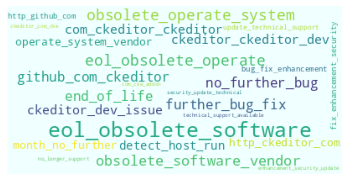

In [19]:
for x in ['vendor', 'month']:
    if x in true_only_list:
        true_only_list.remove(x)

wrdcld = WordCloud(max_words=25, collocations=False, background_color='azure').generate(' '.join(['_'.join(x) for x in true_only_list]))
plt.imshow(wrdcld)
plt.axis('off')
plt.show()

#### feature engineering ####

In [20]:
# df = pd.DataFrame(X_train_vectors_bow)
df = pd.DataFrame.sparse.from_spmatrix(df_train_vectors_bow)
df.shape   # (70, 1789)

(1522, 39962)

In [21]:
df.columns = bow_features

In [18]:
df.loc[0][df.loc[0] == 1]

accepts download of       1
access file user          1
access information web    1
allow attacker read       1
allow file save           1
                         ..
would request user        1
would run security        1
xml object within         1
zone attacker could       1
zone information pass     1
Name: 0, Length: 172, dtype: Sparse[int64, 0]

In [22]:
act_index = {k: v for k, v in enumerate(list(df_train.index))}

In [23]:
df.reset_index(inplace=True)
df['act_index'] = df['index'].map(act_index)
# df['index']
# df

In [24]:
tgt_dict = df_train['is_eol'].to_dict()

In [25]:
df['target'] = df['act_index'].map(tgt_dict)
df['target'].value_counts()

True     837
False    685
Name: target, dtype: int64

In [23]:
# df[df['target'].isna()]
df[['index', 'act_index', 'target']]

,index,act_index,target
0,0,0,False
1,1,1,False
2,2,2,False
3,3,3,False
4,4,4,False
...,...,...,...
1517,1517,1521,True
1518,1518,1522,True
1519,1519,1523,True
1520,1520,1524,False


In [26]:
df.set_index('act_index', inplace=True)
# df

In [27]:
# df.drop(columns='level_0', inplace=True)
df.drop(columns='index', inplace=True)
# df

In [28]:
from nltk import ngrams

#### dimensionality reduction ####

##### pearson correlation #####

In [30]:
cst = datetime.now()
log(f'finding correlation started at {cst}')
df_corr = df.corr(method='pearson')
df_abs_corr = np.abs(df_corr)
cet = datetime.now()
log(f'finding correlation finished at {cet} and took {cet - cst}')
log(df_abs_corr.shape)
#! pickling df_abs_corr is failing. Don't try that

finding correlation started at 2022-08-25 08:22:01.578841


In [29]:
import pickle

In [27]:
#! pickling df_abs_corr is failing. Don't try that
# with open('df_abs_corr.pkl', 'wb') as fp:
#     pickle.dump(df_abs_corr, fp)

: 

: 

In [19]:
df_abs_corr.shape

(39963, 39963)

In [21]:
# df_corr = df.corr(method='pearson')
# df_abs_corr = np.abs(df_corr)
# df_abs_corr

,accord self reported,accordingly red hat,administrator highly urge,adobe flash player,adobe no longer,advsearch asp direct,allow remote code,already vulnerable exploit,amaya udhay shankar,apache might numerous,...,vulnerability recommend upgrade,vulnerability thus recommend,vulnerable critical security,vulnerable security flaw,web browser plug,willconclude accordingly red,window xp end,xml core service,xp end of,target
accord self reported,1.000000,0.022727,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.075378
accordingly red hat,0.022727,1.000000,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,1.000000,0.022727,0.022727,0.022727,0.075378
administrator highly urge,0.022727,0.022727,1.000000,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.075378
adobe flash player,0.032171,0.032171,0.032171,1.000000,0.989489,0.032171,0.032171,0.046023,0.032171,0.032171,...,0.032171,0.032171,0.989489,0.032171,0.795085,0.032171,0.032171,0.032171,0.032171,0.106699
adobe no longer,0.032513,0.032513,0.032513,0.989489,1.000000,0.032513,0.032513,0.046512,0.032513,0.032513,...,0.032513,0.032513,1.000000,0.032513,0.699025,0.032513,0.032513,0.032513,0.032513,0.107833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
willconclude accordingly red,0.022727,1.000000,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,1.000000,0.022727,0.022727,0.022727,0.075378
window xp end,0.022727,0.022727,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,0.022727,1.000000,0.022727,1.000000,0.075378
xml core service,0.022727,0.022727,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,0.022727,0.022727,1.000000,0.022727,0.075378
xp end of,0.022727,0.022727,0.022727,0.032171,0.032513,0.022727,0.022727,0.032513,0.022727,0.022727,...,0.022727,0.022727,0.032513,0.022727,0.022727,0.022727,1.000000,0.022727,1.000000,0.075378


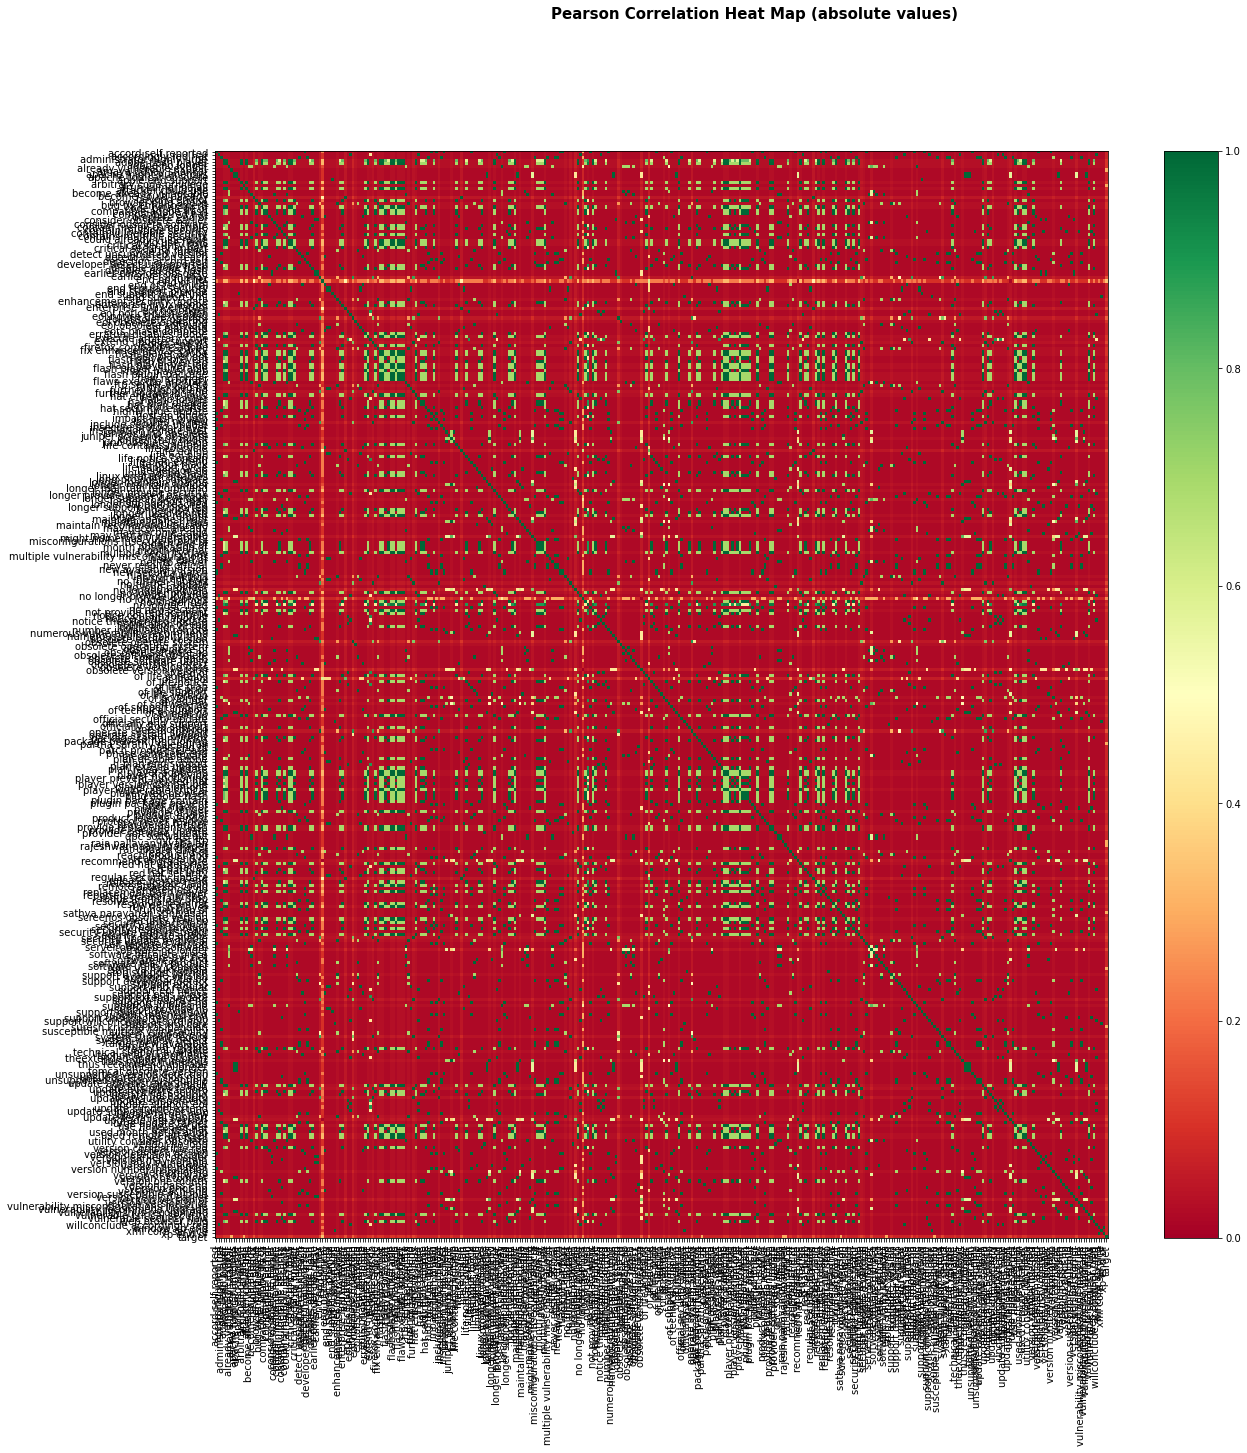

In [22]:
plt.figure(figsize=(20, 20))
plt.imshow(df_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(df_abs_corr)), df_abs_corr.columns, rotation='vertical')
plt.yticks(range(len(df_abs_corr)), df_abs_corr.columns)
plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
plt.show()

##### univariate feature removal #####

In [20]:
CORRELATION_MIN = 0.1
CORRELATION_MAX = 0.8
s_corr_target = df_abs_corr['target']
s_corr_target_sort = s_corr_target.sort_values(ascending=False)
s_low_correlation_ftrs = s_corr_target_sort[s_corr_target_sort <= CORRELATION_MIN]
print(f"Removed {len(s_low_correlation_ftrs)} low correlation features:")
for i,v in enumerate(s_low_correlation_ftrs):
    print(i,np.round(v, 4), s_low_correlation_ftrs.index[i])
s_corr_target_sort = s_corr_target_sort[s_corr_target_sort > CORRELATION_MIN]


Removed 39745 low correlation features:
0 0.099 vendor of month
1 0.099 vendor detect support
2 0.099 detect vendor end
3 0.099 look registry key
4 0.0985 sdk compiler allow
5 0.0985 linux ibm system
6 0.0985 enterprise linux ibm
7 0.0985 xred hat enterprise
8 0.0985 apple mac os
9 0.0967 enterprise linux power
10 0.0961 key file see
11 0.0961 logic authenticate review
12 0.0961 life month no
13 0.0961 binary underlying version
14 0.0961 version affect version
15 0.0961 end month detection
16 0.0961 of life eol
17 0.0961 longer support vendor
18 0.0955 update available kb
19 0.0952 no longer release
20 0.0952 longer release security
21 0.0943 attacker execute arbitrary
22 0.0943 window xp embed
23 0.0943 windows os linux
24 0.0943 player windows os
25 0.0943 compiler allow attacker
26 0.0943 cve vendor flash
27 0.0941 ppc lered hat
28 0.0932 pack detect host
29 0.0932 specific service pack
30 0.0932 service pack level
31 0.0932 support specific service
32 0.0932 file see vendor
33 0.09

In [21]:
print(f"Remaining {len(s_corr_target_sort)-1} feature correlations:")
for i,v in enumerate(s_corr_target_sort):
    ftr = s_corr_target_sort.index[i]
    if ftr == 'target':
        continue
    print(i,np.round(v, 8), ftr)

Remaining 217 feature correlations:
1 0.63751123 eol obsolete software
2 0.41853265 release security update
3 0.38806639 fix vulnerability affect
4 0.37285506 eol obsolete operate
5 0.37285506 obsolete operate system
6 0.37087914 obsolete software vendor
7 0.34474559 no further bug
8 0.3437968 vendor release security
9 0.34372202 further bug fix
10 0.3133045 detect host run
11 0.29912391 operate system vendor
12 0.29556436 detection logic authenticate
13 0.28906484 month no further
14 0.28452338 fix enhancement security
15 0.28452338 bug fix enhancement
16 0.28223522 update technical support
17 0.28108665 technical support available
18 0.27993503 security update technical
19 0.27993503 enhancement security update
20 0.27711957 vulnerability affect vendor
21 0.2753323 no longer support
22 0.27070212 end of life
23 0.27060721 end month no
24 0.26586194 provide no further
25 0.25619242 no further support
26 0.24751633 no further update
27 0.24118273 support available version
28 0.2404704 

##### step 2 #####

In [22]:
CORRELATION_MAX = 0.8

df1_cols = list(set(s_corr_target_sort.index) - set(s_low_correlation_ftrs.index))

df1 = df[df1_cols]
df1_corr = df1.corr(method='pearson')
df1_abs_corr = np.abs(df1_corr)
df1_abs_corr

# Get all the feature pairs
Xcorr1 = df1_abs_corr.iloc[1:,1:]
s_pairs = Xcorr1.unstack()
print("s_pairs.shape", s_pairs.shape)
s_pairs = np.round(s_pairs, decimals=4)

# Sort all the pairs by highest correlation values
s_pairs_sorted = s_pairs.sort_values(ascending=False) 
s_pairs_sorted = s_pairs_sorted[(s_pairs_sorted != 1) & (s_pairs_sorted > CORRELATION_MAX)]  # leave only the top matches that are not identical features

# Convert to a list of name tuples e.g. ('mean radius', 'mean perimeter')
li_corr_pairs = s_pairs_sorted.index.tolist()

print("len(li_corr_pairs):", len(li_corr_pairs))
print("li_corr_pairs[:10]", li_corr_pairs[:10])

s_pairs.shape (47089,)
len(li_corr_pairs): 566
li_corr_pairs[:10] [('ptf bos rte', 'security package aix'), ('miss ptf bos', 'ptf bos rte'), ('ptf bos rte', 'miss ptf bos'), ('ptf bos rte', 'rte security package'), ('bos rte security', 'ptf bos rte'), ('security package aix', 'ptf bos rte'), ('ptf bos rte', 'bos rte security'), ('rte security package', 'ptf bos rte'), ('no further bug', 'further bug fix'), ('further bug fix', 'no further bug')]


In [23]:
from collections import OrderedDict

In [24]:
# Build list of features to remove
li_remove_pair_ftrs = []
li_remove_scores = []
for tup in li_corr_pairs:
    s0 = s_corr_target_sort.loc[tup[0]]
    s1 = s_corr_target_sort.loc[tup[1]]
    remove_ftr = tup[1] if s1 < s0 else tup[0]  # get the feature that is less correlated with the target
    if remove_ftr not in li_remove_pair_ftrs:
        li_remove_pair_ftrs.append(remove_ftr)
        di = {'ftr_0':tup[0], 'ftr_1':tup[1], 'score_0':s0, 'score_1':s1, 'FEATURE_TO_REMOVE':remove_ftr}
        li_remove_scores.append(OrderedDict(di))
   
df_remove_scores = pd.DataFrame(li_remove_scores)
print("Removing %d features (see last column):" % len(li_remove_pair_ftrs))
print(df_remove_scores.to_string())
print("---")

# Remove the features that were found in the above procedure
li_X2_cols = list(set(df1_cols) - set(li_remove_pair_ftrs)) 
li_X2_cols.sort()

print("Remaining %d features:" % (len(li_X2_cols)))
for i,v in enumerate(s_corr_target_sort):
  ftr = s_corr_target_sort.index[i]

  if ftr in li_X2_cols:
    print(i,np.round(v, 4), ftr)

Removing 89 features (see last column):
                            ftr_0                          ftr_1   score_0   score_1              FEATURE_TO_REMOVE
0                     ptf bos rte           security package aix  0.233010  0.231595           security package aix
1                    miss ptf bos                    ptf bos rte  0.234421  0.233010                    ptf bos rte
2                     ptf bos rte           rte security package  0.233010  0.231595           rte security package
3                bos rte security                    ptf bos rte  0.231595  0.233010               bos rte security
4                  no further bug                further bug fix  0.344746  0.343722                further bug fix
5             bug fix enhancement       update technical support  0.284523  0.282235       update technical support
6     enhancement security update       update technical support  0.279935  0.282235    enhancement security update
7        update technical suppor

In [25]:
df2 = df1[li_X2_cols]

df2_corr = df2.corr(method='pearson')
df2_abs_corr = np.abs(df2_corr)
df2_abs_corr
# print("After the pair feature reduction, X2.shape:", X2.shape)
# yX2, yX_corr2, yX_abs_corr2 = correlation_matrix(y_train, X2)

# Recalculate the correlation matrix in order to plot the TARGET values in order of correlation
s_X3_cols = df2_abs_corr['target'].sort_values(ascending=False)
df3_cols = s_X3_cols.index.tolist()
print("Remaining features:")
print(s_X3_cols)
print("---")

df3 = df2[df3_cols]
print("After the pair feature reduction, df3.shape:", df3.shape)


Remaining features:
target                      1.000000
eol obsolete software       0.637511
release security update     0.418533
eol obsolete operate        0.372855
obsolete operate system     0.372855
                              ...   
debian release security     0.102599
debian security update      0.102599
support specific version    0.101714
totibco end of              0.101714
allow remote attacker       0.100988
Name: target, Length: 129, dtype: float64
---
After the pair feature reduction, df3.shape: (1522, 129)


In [36]:
final_df_train_cols = df3_cols
df_train_final = df3

In [26]:
df3_cols

['target',
 'eol obsolete software',
 'release security update',
 'eol obsolete operate',
 'obsolete operate system',
 'obsolete software vendor',
 'no further bug',
 'detect host run',
 'operate system vendor',
 'detection logic authenticate',
 'month no further',
 'vulnerability affect vendor',
 'no longer support',
 'end of life',
 'provide no further',
 'no further update',
 'aix miss ptf',
 'vendor security update',
 'system vendor detect',
 'vendor end support',
 'regular patch detection',
 'patch detection logic',
 'vulnerability affect product',
 'host run vendor',
 'directly security advisory',
 'extract directly security',
 'advisory use automation',
 'automation attempt clean',
 'security advisory use',
 'use automation attempt',
 'block extract directly',
 'description block extract',
 'attempt clean format',
 'vendor detect vendor',
 'support vendor end',
 'vendor vendor release',
 'pack sp detect',
 'since no further',
 'fix security update',
 'bug fix security',
 'linux 

In [29]:
df3.head()

,target,cumulative security update,security update internet,update internet explorer,internet explorer cumulative,explorer cumulative security,end of life,markup language vulnerability,code execution sathya,sathya narayanan srinivasan,...,technical support available,eol obsolete operating,security update technical,bug fix enhancement,enhancement security update,no further bug,obsolete operating system,further bug fix,fix enhancement security,extend update support
act_index,,,,,,,,,,,,,,,,,,,,,
0,True,0,0,0,0,0,1,0,0,0,...,1,0,1,1,1,1,0,1,1,0
1,True,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,1,0
2,True,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,True,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Export reduced dimensions #####

In [37]:
with open('column_list_v2.txt', 'w') as f:
    print(*final_df_train_cols, sep='\n', file=f)

In [10]:
with open('column_list_v2.txt', 'r') as f:
    final_df_train_cols = [i.replace('\n', '') for i in f]

In [20]:
df3 = df[final_df_train_cols]
df3.shape

(1522, 129)

#### split ####

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df3, df3['target'], test_size=0.2, random_state=0)
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

X_train.shape, y_train.shape (1217, 129) (1217,)
X_test.shape, y_test.shape (305, 129) (305,)


### Grid search Cross Validation ###

In [22]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg, param_grid=parameters, scoring='accuracy', cv=3)

In [25]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [26]:
tuned_hyperparams = clf.best_params_
print('Tuned Hyperparameters :', tuned_hyperparams)
print('Accuracy :', clf.best_score_)

Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 1.0


#### class balancing ####

In [27]:
# getting class weights to handle imbalance
from sklearn.model_selection import StratifiedKFold
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator=logreg, 
                          param_grid=param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='accuracy')
gridsearch.fit(X_train, y_train)

/home/prajendiran/riskfusion/scripts/env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/prajendiran/riskfusion/scripts/env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/prajendiran/riskfusion/scripts/env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/prajendiran/riskfusion/scripts/env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/prajendiran/riskfusion/scripts/env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: panda

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.9801005025125629},
                                          {0: 0.02...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
          

In [28]:
weigh_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1-weights)})
weigh_data

,score,weight
0,0.543139,1.000000
1,0.543139,0.995025
2,0.635165,0.990050
3,0.751832,0.985075
4,0.966316,0.980101
...,...,...
195,0.940039,0.029899
196,0.935937,0.024925
197,0.927720,0.019950
198,0.889108,0.014975


In [29]:
weigh_data[weigh_data['score'] == weigh_data['score'].max()]

,score,weight
7,1.0,0.965176
8,1.0,0.960201
9,1.0,0.955226
10,1.0,0.950251
11,1.0,0.945276
...,...,...
170,1.0,0.154271
171,1.0,0.149296
172,1.0,0.144322
173,1.0,0.139347


In [30]:
cls1_weight = weigh_data[weigh_data['score'] == weigh_data['score'].max()]['weight'].mean()
cls0_weight = 1 - cls1_weight
{0: cls0_weight, 1: cls1_weight}

{0: 0.45022613065326633, 1: 0.5497738693467337}

In [31]:
tuned_hyperparams['class_weight'] = {0: cls0_weight, 1: cls1_weight}
tuned_hyperparams

{'C': 0.01,
 'penalty': 'l1',
 'solver': 'liblinear',
 'class_weight': {0: 0.45022613065326633, 1: 0.5497738693467337}}

### Logistic Regression with tuned parameters ###

In [32]:
# clf_lr = LogisticRegression(class_weight='balanced', dual=False, 
#           fit_intercept=True, intercept_scaling=1, max_iter=200,
#           n_jobs=1, random_state=0, tol=0.0001, verbose=0, warm_start=False)

# clf_lr = LogisticRegression(solver='liblinear', C=10, penalty = 'l2')
# clf_lr = LogisticRegression(solver='liblinear', C=1, penalty = 'l1') # best_params_ from GridSearchCV
clf_lr = LogisticRegression(**tuned_hyperparams) # best_params_ from GridSearchCV

In [33]:
clf_lr.fit(X_train, y_train)

LogisticRegression(C=0.01,
                   class_weight={0: 0.45022613065326633, 1: 0.5497738693467337},
                   penalty='l1', solver='liblinear')

,target,eol obsolete software,release security update,eol obsolete operate,obsolete operate system,obsolete software vendor,no further bug,detect host run,operate system vendor,detection logic authenticate,...,detect vendor vendor,version of ibm,release security patch,suse su suse,windows xp embed,debian release security,debian security update,support specific version,totibco end of,allow remote attacker
act_index,,,,,,,,,,,,,,,,,,,,,
864,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
958,False,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1142,False,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
733,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309,True,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
y_pred = clf_lr.predict(X_test)
y_score = clf_lr.predict_proba(X_test)

In [36]:
lr_bow_intercept = clf_lr.intercept_[0]
log_odds = clf_lr.coef_[0]
df_lr_bow_coef = pd.DataFrame(log_odds, final_df_train_cols, columns=['coef'])\
            .sort_values(by='coef', ascending=False)
df_lr_bow_coef.shape

(129, 1)

In [46]:
lr_bow_intercept

0.0

In [47]:
df_lr_bow_coef.head(50)

,coef
target,0.968505
information regard security,0.000000
vendor security notification,0.000000
could allow remote,0.000000
detect vendor office,0.000000
migrate version newer,0.000000
version newer support,0.000000
sp detect host,0.000000
of life month,0.000000
server service pack,0.000000


In [48]:
df_lr_bow_coef.to_csv('manipulated_data.csv')

2022-08-22 12:55:10.349092
True Positive :     176		False Positive :       0
True Negative :     129		False Negative :       0
Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


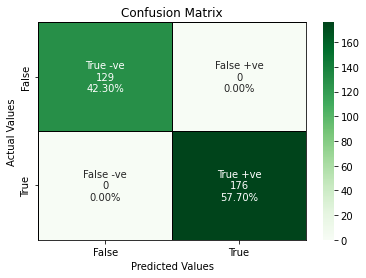

In [37]:
from datetime import datetime
print(datetime.now())
show_metrics(y_test, y_pred)

##### old metrics #####

2022-05-25 17:26:47.009323
True Positive :       6		False Positive :       0
True Negative :       3		False Negative :       0


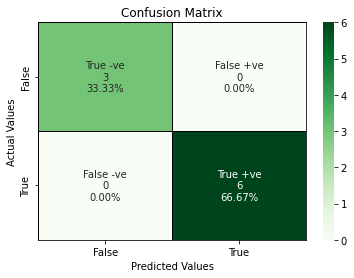

Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


In [42]:
from datetime import datetime
print(datetime.now())
show_metrics(y_test, y_pred)

2022-05-23 15:24:49.123378
True Positive :       6		False Positive :       0
True Negative :       3		False Negative :       0


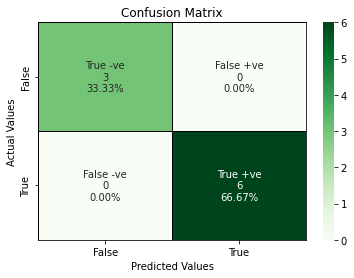

Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


In [39]:
from datetime import datetime
print(datetime.now())
show_metrics(y_test, y_pred)

2022-05-04 17:17:21.201779
True Positive :       5		False Positive :       0
True Negative :       9		False Negative :       0


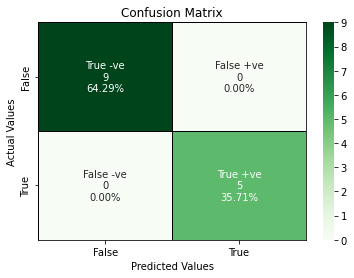

Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


In [94]:
from datetime import datetime
print(datetime.now())
show_metrics(y_test, y_pred)

True Positive :       5		False Positive :       0
True Negative :       9		False Negative :       0


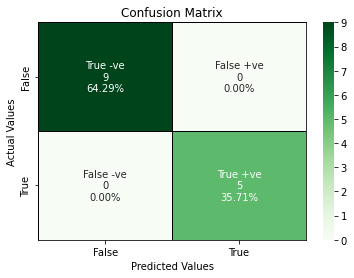

Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


In [36]:
show_metrics(y_test, y_pred)

True Positive :       3		False Positive :       0
True Negative :       6		False Negative :       0


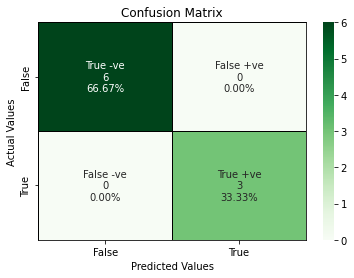

Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


In [36]:
show_metrics(y_test, y_pred)

True Positive :       3		False Positive :       4
True Negative :       2		False Negative :       0


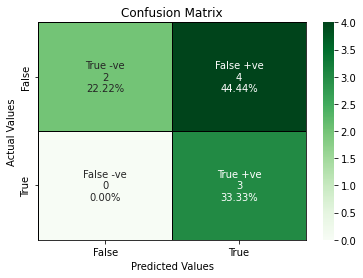

Precision : 0.4286
Recall    : 1.0
Accuracy  : 55.5556%
F1 score  : 0.6


In [179]:
# show_metrics(y_test, y_pred)

True Positive :       3		False Positive :       4
True Negative :       2		False Negative :       0


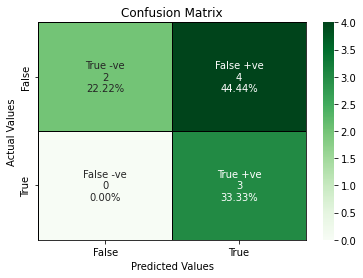

Precision : 0.4286
Recall    : 1.0
Accuracy  : 55.5556%
F1 score  : 0.6


In [175]:
# show_metrics(y_test, y_pred)

#### Exporting model ####

In [50]:
import pickle
with open(pickle_path + 'bow_vectorizer.pkl', 'wb') as fo:
    pickle.dump(bow_vectorizer, fo)

with open(pickle_path + 'lr_bow.pkl', 'wb') as fo:
    pickle.dump(clf_lr, fo)


### Bernouli Naive Bayse ###

In [76]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

log = print
model_name = 'Bernoulli Naive Bayse with BoW'
log('{:-^100}'.format(model_name))
prev_score = 0
# https://datascience.stackexchange.com/questions/30473/how-does-the-mutlinomial-bayess-alpha-parameter-affects-the-text-classificati
for alpha in np.arange(0.1, 1.1, 0.1):
    sub_classifier = BernoulliNB(alpha=alpha)
    sub_classifier.fit(X_train, y_train)
    y_pred = sub_classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    alpha_msg = f'alpha: {alpha:.1g}\tscore: {score}'
    if score > prev_score:
        log(f'{alpha_msg}\tSelected alpha : {alpha:.1g}')
        bnb_bow = sub_classifier
        prev_score = score
    else:
        log(alpha_msg)

-----------------------------------Bernoulli Naive Bayse with BoW-----------------------------------
alpha: 0.1	score: 1.0	Selected alpha : 0.1
alpha: 0.2	score: 1.0
alpha: 0.3	score: 1.0
alpha: 0.4	score: 0.9934426229508196
alpha: 0.5	score: 0.9934426229508196
alpha: 0.6	score: 0.9934426229508196
alpha: 0.7	score: 0.9934426229508196
alpha: 0.8	score: 0.9934426229508196
alpha: 0.9	score: 0.9934426229508196
alpha: 1	score: 0.9934426229508196


True Positive :     176		False Positive :       0
True Negative :     129		False Negative :       0
Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


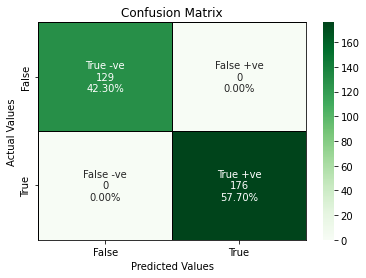

In [88]:
y_predict = bnb_bow.predict(X_test)
y_prob = bnb_bow.predict_proba(X_test)[:,1]
show_metrics(y_test, y_predict)

AUC: 1.0


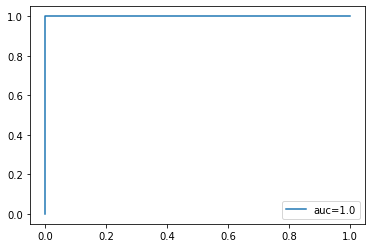

In [90]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')
auc_score = roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="auc=" + str(auc_score))
plt.legend(loc=4)
plt.show()

In [91]:
optimal_idx = np.argmax(tpr - fpr)
bnb_bow_optimal_threshold = thresholds[optimal_idx]
optimal_idx, bnb_bow_optimal_threshold, tpr[optimal_idx] - fpr[optimal_idx]
bnb_bow_optimal_threshold

0.7472919291384891

### Ridge Classifier ###

In [109]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
print(rc)
rc.fit(X_train, y_train)

RidgeClassifier()


RidgeClassifier()

In [110]:
y_pred = rc.predict(X_test)

True Positive :     176		False Positive :       0
True Negative :     129		False Negative :       0
Precision : 1.0
Recall    : 1.0
Accuracy  : 100.0000%
F1 score  : 1.0


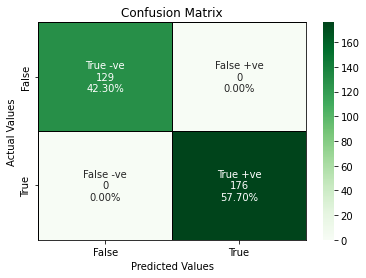

In [111]:
show_metrics(y_test, y_pred)

In [98]:
parameters = {
    'alpha':[550, 580, 600, 620, 650]
}

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(rc, param_grid=parameters, scoring='accuracy', cv=5)

In [101]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [550, 580, 600, 620, 650]},
             scoring='accuracy')

In [102]:
tuned_hyperparams = clf.best_params_
tuned_hyperparams['class_weight'] = {0: 0.22386934673366832, 1: 0.7761306532663317}
print('Tuned Hyperparameters :', tuned_hyperparams)
print('Accuracy :', clf.best_score_)

Tuned Hyperparameters : {'alpha': 550, 'class_weight': {0: 0.22386934673366832, 1: 0.7761306532663317}}
Accuracy : 1.0


In [103]:
rc = RidgeClassifier(**tuned_hyperparams)
rc.fit(X_train, y_train)

RidgeClassifier(alpha=550,
                class_weight={0: 0.22386934673366832, 1: 0.7761306532663317})

In [104]:
y_pred = rc.predict(X_test)

True Positive :     175		False Positive :     123
True Negative :       6		False Negative :       1
Precision : 0.5872
Recall    : 0.9943
Accuracy  : 59.3443%
F1 score  : 0.7384


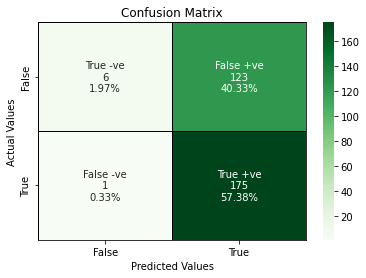

In [105]:
show_metrics(y_test, y_pred)

### SVM ###

In [127]:
from sklearn.svm import SVC
svm = SVC(probability=True)
svm.fit(X_train, y_train)

SVC(probability=True)

True Positive :     176		False Positive :       1
True Negative :     128		False Negative :       0
Precision : 0.9944
Recall    : 1.0
Accuracy  : 99.6721%
F1 score  : 0.9972


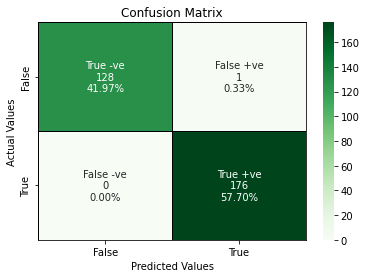

In [129]:
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:,1]
show_metrics(y_test, y_pred)

AUC: 0.9999999999999999


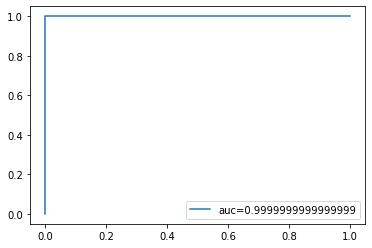

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')
auc_score = roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="auc=" + str(auc_score))
plt.legend(loc=4)
plt.show()

In [132]:
optimal_idx = np.argmax(tpr - fpr)
svm_optimal_threshold = thresholds[optimal_idx]
optimal_idx, bnb_bow_optimal_threshold, tpr[optimal_idx] - fpr[optimal_idx]
svm_optimal_threshold

0.9423846349412272

### Data to predict ###

#### Data Prep ####

In [59]:
from datetime import datetime
db_name = 'scap'
source_name = 'ALL'
read_from = 'preprocessed'

st = datetime.now()
# flog = open(f'{eol_path}logs/eol_lr_prediction_log_{st.strftime("%Y%m%d%H%M%S")}.log', 'w')
# def log(msg):
#     print(f'{datetime.now()} : {msg}')
#     flog.write(f'{datetime.now()} : {msg}\n')

log(f'started at {st}')


started at 2022-08-22 13:12:19.227825


In [52]:
preprocessed_file_name = f'{eol_path}{db_name}_{source_name}_preprocessed_data.csv'
file_name = preprocessed_file_name
dfs = [pd.read_csv(file_name)]
log(f'Read the df of shape {dfs[0].shape} from {file_name}')

2022-08-17 16:07:42.880108 : Read the df of shape (879876, 5) from /home/prajendiran/riskfusion/sources/eol/scap_ALL_preprocessed_data.csv


In [53]:
dfs[0] = dfs[0][~((dfs[0]['title'].isnull()) & (dfs[0]['description'].isnull()))]
log(f'df shape after ignoring records without title and description is {dfs[0].shape}')

2022-08-17 16:07:48.494482 : df shape after ignoring records without title and description is (879876, 5)


In [55]:
df = dfs[0]
df.fillna('', inplace=True)
df.shape

(879876, 5)

In [ ]:
df['title'] = df['title'].replace(np.nan, '')
df['description'] = df['description'].replace(np.nan, '')
df['clean_desc'] = df['title'].values + ' ' + df['description'].values
df['clean_desc'] = df['clean_desc'].apply(pre_process)

In [54]:
from eol_utils import cleanse_text
v_cleanse_text = np.vectorize(cleanse_text)

In [ ]:
def pre_process_df(df):
    log(f'{datetime.now()} : Pre processing')
    df['title'] = df['title'].astype(str)
    log('df.title converted to str')
    df['description'] = df['description'].astype(str)
    log('df.description converted to str')
    # df['clean_desc'] = df['description'].apply(pre_process)
    # df['clean_desc'] = df['title'].apply(cleanse_title) + ' ' + df['description']
    df['clean_desc'] = df['title'].values + ' ' + df['description'].values
    log('df.title and df.description appended')
    # df['clean_desc'] = df['clean_desc'].apply(pre_process)
    df['clean_desc'] = v_cleanse_text(df['clean_desc'].values)
    log('pre_process function applied')
    # exit()
    df.to_csv(preprocessed_file_name, index=False)
    log('exported preprocessed data to ' + preprocessed_file_name)
    return df


In [56]:
df['title'] = df['title'].replace(np.nan, '')
df['description'] = df['description'].replace(np.nan, '')

In [58]:
df['title'] = df['title'].astype(str)
df['description'] = df['description'].astype(str)

In [59]:
df['clean_desc'] = df['title'].values + ' ' + df['description'].values

In [60]:
pst = datetime.now()
print(pst)
df['clean_desc'] = df['clean_desc'].apply(pre_process)
pet = datetime.now()
print(pet)

2022-08-17 16:15:02.784855
2022-08-17 17:57:12.209911


In [67]:
df.to_csv('scap_ALL_preprocessed_data.csv', index=False)

In [41]:
df = pd.read_csv('scap_ALL_preprocessed_data.csv')
df.fillna('', inplace=True)
df.shape

(879876, 5)

In [1]:
from eol_utils import cleanse_text

confirmed_phrases = [
    'end of life', 
    'eol obsolete', 
    'no longer maintain', 
    'no longer support',
    'has reached end of life',
    'end of support',
    'no longer officially support',
    'has officially stopped support for',
    'has passed its end of life',
    'considered obsolete',
    'eol obsolete software', 
    'obsolete operating system', 
    'eol obsolete operating', 
    'no longer supported', 
    'ended support for', 
    'no further support', 
    'unsupported version of', 
    'beyond end of', 
    'obsolete piece of software'
]
confirmed_trigrams = [
    'end of life', 'officially stop support', 'no longer support', 'pass end of', 'eol no longer', 'beyond end of', 'reach end of',
    'of life eol', 'earlier consider obsolete',
    'eol obsolete software', 'obsolete operating system', 'eol obsolete operating', 'no longer supported', 'ended support for', 
    'no further support', 'unsupported version of', 'is considered obsolete'
]
def get_eol_phrases(desc):
    return ', '.join([phr for phr in confirmed_phrases if phr in desc])

v_get_eol_phrases = np.vectorize(get_eol_phrases)
v_cleanse_text = np.vectorize(cleanse_text)
def pre_process_df(df):
    log(f'{datetime.now()} : Pre processing')
    df['title'] = df['title'].astype(str)
    log('df.title converted to str')
    df['description'] = df['description'].astype(str)
    log('df.description converted to str')
    # df['clean_desc'] = df['description'].apply(pre_process)
    # df['clean_desc'] = df['title'].apply(cleanse_title) + ' ' + df['description']
    df['clean_desc'] = df['title'].values + ' ' + df['description'].values
    log('df.title and df.description appended')
    # df['clean_desc'] = df['clean_desc'].apply(pre_process)
    df['clean_desc'] = v_cleanse_text(df['clean_desc'].values)
    log('pre_process function applied')
    # exit()
    # df.to_csv(preprocessed_file_name, index=False)
    # log('exported preprocessed data to ' + preprocessed_file_name)
    return df


NameError: name 'np' is not defined

In [2]:
print(*confirmed_phrases, sep='\n')

end of life
eol obsolete
no longer maintain
no longer support
has reached end of life
end of support
no longer officially support
has officially stopped support for
has passed its end of life
considered obsolete
eol obsolete software
obsolete operating system
eol obsolete operating
no longer supported
ended support for
no further support
unsupported version of
beyond end of
obsolete piece of software


#### vectorization (old method) ####

In [7]:
import pickle
with open(pickle_path + 'bow_vectorizer.pkl', 'rb') as fo:
    bow_vectorizer = pickle.load(fo)
    bow_features = bow_vectorizer.get_feature_names_out()

with open(pickle_path + 'lr_bow.pkl', 'rb') as fo:
    lr_bow = pickle.load(fo)

In [8]:
X_test = df['clean_desc']
X_vector_bow = bow_vectorizer.transform(X_test)

In [9]:
y_predict = lr_bow.predict(X_vector_bow)
y_prob = lr_bow.predict_proba(X_vector_bow)[:,1]
df['lr_bow_predict_prob'] = y_prob
df['lr_bow_is_eol'] = y_predict

In [10]:
df['lr_bow_is_eol'].value_counts()

True     872147
False      7729
Name: lr_bow_is_eol, dtype: int64

In [11]:
df

,plugin_id,scanner,title,description,clean_desc,lr_bow_predict_prob,lr_bow_is_eol
0,BEYONDSECURITY36081,BEYONDSECURITY,,The FTP service allows anonymous logins. If yo...,the ftp service allows anonymous logins if you...,0.795853,True
1,BEYONDSECURITY36084,BEYONDSECURITY,,printenv CGI is installed. This CGI usually re...,printenv cgi is installed this cgi usually ret...,0.795853,True
2,BEYONDSECURITY36085,BEYONDSECURITY,,printenv CGI is installed. This CGI usually re...,printenv cgi is installed this cgi usually ret...,0.795853,True
3,BEYONDSECURITY36087,BEYONDSECURITY,,The server's statistics have been found at: /w...,the server s statistics have been found at web...,0.795853,True
4,BEYONDSECURITY36090,BEYONDSECURITY,,We found some common directories on the web se...,we found some common directories on the web se...,0.795853,True
...,...,...,...,...,...,...,...
879871,6696CEEA1D7B46666A6360EE785F0ED5E67235A52CA795...,NESSUS,3.2.1 Ensure source routed packets are not acc...,"""3.2.1 Ensure source routed packets are not ac...",ensure source routed packets are not accepted ...,0.795853,True
879872,A40DBB4CD8EBF069EEDCDAB3D5733AF1F5470E83898229...,NESSUS,1.2.2 Disable the rhnsd Daemon,"""1.2.2 Disable the rhnsd Daemon"" : </br></br>T...",disable the rhnsd daemon disable the rhnsd dae...,0.795853,True
879873,081D043CF5D5F0B0C2B2171563D57B805528A6230D9AB9...,NESSUS,MBSS-OS-RHEL7-018 - 1.1.11 (L2) Ensure separat...,"""MBSS-OS-RHEL7-018 - 1.1.11 (L2) Ensure separa...",mbss os rhel l ensure separate partition exist...,0.795853,True
879874,900409B71F3867F34A8830944AE532A796051E85F8CA6D...,NESSUS,4.1.11 Ensure unsuccessful unauthorized file a...,"""4.1.11 Ensure unsuccessful unauthorized file ...",ensure unsuccessful unauthorized file access a...,0.795853,True


In [45]:
df.head(3)

,plugin_id,scanner,title,description,clean_desc
0,BEYONDSECURITY36081,BEYONDSECURITY,,The FTP service allows anonymous logins. If yo...,the ftp service allows anonymous logins if you...
1,BEYONDSECURITY36084,BEYONDSECURITY,,printenv CGI is installed. This CGI usually re...,printenv cgi is installed this cgi usually ret...
2,BEYONDSECURITY36085,BEYONDSECURITY,,printenv CGI is installed. This CGI usually re...,printenv cgi is installed this cgi usually ret...


#### vectorization (new method) ####

In [43]:
X_pred = df['clean_desc']
X_vector_bow = bow_vectorizer.transform(X_pred)

In [63]:
X_vector_bow.shape # (879876, 1789)  (879876, 1685)  (879876, 404)

(879876, 39962)

In [44]:
df_sp = pd.DataFrame.sparse.from_spmatrix(X_vector_bow)
df_sp.shape

(879876, 39962)

In [45]:
df_sp.columns = bow_features

In [68]:
len(final_df_train_cols), len(df3.columns), len(df_sp.columns) # (1361, 1789)  (124, 404)

(129, 129, 39962)

In [46]:
req_columns = final_df_train_cols #list(df3.columns)
req_columns.remove('target')
additional_columns = list(set(df_sp.columns) - set(final_df_train_cols))
len(req_columns), len(additional_columns) # (1360, 429)  (1167, 518)  (123, 281)

(128, 39834)

In [54]:
df_sp[additional_columns].sum().sum() # 410163  316311  74715

74709

In [55]:
df_sp[req_columns].sum().sum() # 991121  1066395  338807

209831

In [56]:
df_sp.head(5)

,accord self reported,accordingly red hat,administrator highly urge,adobe flash player,adobe no longer,already vulnerable exploit,amaya udhay shankar,apache might numerous,apache tomcat obsolete,apple end support,...,vulnerability misconfigurations insecure,vulnerability recommend upgrade,vulnerability thus recommend,vulnerable critical security,vulnerable security flaw,web browser plug,willconclude accordingly red,window xp end,xml core service,xp end of
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_pred = df_sp[req_columns]
df_pred['target'] = 0
df_pred.shape  # (879876, 1168)  (879876, 124)

(879876, 129)

#### LR Prediction ####

In [48]:
y_predict = clf_lr.predict(df_pred)
y_proba = clf_lr.predict_proba(df_pred)[:,1]

In [49]:
df['lr_bow_predict_prob'] = y_proba
df['lr_bow_is_eol'] = y_predict

In [50]:
df_pred.shape, df.shape

((879876, 129), (879876, 7))

In [51]:
print(datetime.now())
df['lr_bow_is_eol'].value_counts()
# False    877052
# True       2824

# False    879450
# True        426

# False    879349
# True        527

# 2022-05-25 17:31:37.210707
# False    879450
# True        426

# 2022-08-22 13:01:58.823295
# False    879295
# True        581

2022-08-22 13:01:58.823295


False    879295
True        581
Name: lr_bow_is_eol, dtype: int64

In [65]:
df[df['eol_phrases'] !=''].shape

(1953, 8)

In [52]:
df[df['lr_bow_is_eol'] == True]

,plugin_id,scanner,title,description,clean_desc,lr_bow_predict_prob,lr_bow_is_eol
19349,QUALYS105442,QUALYS,EOL/Obsolete Software: Apache HTTP Server 1.3....,The Apache Software Foundation and the Apache ...,eol obsolete software vendor http server x det...,0.724821,True
19350,QUALYS105470,QUALYS,EOL/Obsolete Software: Apache Tomcat 5.5.x Det...,Apache Tomcat software is a web server.\n<P>\n...,eol obsolete software vendor tomcat x detect v...,0.724821,True
19353,QUALYS105506,QUALYS,EOL/Obsolete Software: ISC BIND 9.7.x Detected,The host is running BIND. ISC BIND ended suppo...,eol obsolete software isc bind x detect host r...,0.724821,True
19354,QUALYS105522,QUALYS,EOL/Obsolete Software: Microsoft SQL Server 20...,Microsoft SQL Server 2008 is a data management...,eol obsolete software vendor sql server r serv...,0.724821,True
19503,QUALYS19731,QUALYS,EOL/Obsolete Software: MySQL 5.0.x Detected,MySQL version 5.0 is detected on the host. \n<...,eol obsolete software mysql x detect mysql ver...,0.724821,True
...,...,...,...,...,...,...,...
847791,QUALYS105987,QUALYS,EOL/Obsolete Software: Hypertext Preprocessor ...,PHP is a general purpose scripting language th...,eol obsolete software hypertext preprocessor p...,0.724821,True
852274,QUALYS105981,QUALYS,EOL/Obsolete Software: Microsoft SQL Server 20...,Microsoft SQL Server 2014 is a data management...,eol obsolete software vendor sql server servic...,0.724821,True
852275,QUALYS105982,QUALYS,EOL/Obsolete Software: Microsoft SQL Server 20...,Microsoft SQL Server 2012 is a data management...,eol obsolete software vendor sql server servic...,0.724821,True
855613,QUALYS105997,QUALYS,EOL/Obsolete Software: Symantec Endpoint Prote...,"Symantec Endpoint Protection, developed by Bro...",eol obsolete software symantec endpoint protec...,0.724821,True


In [53]:
df['eol_phrases'] = v_get_eol_phrases(df['clean_desc'].values)

In [54]:
def chunk_df(df, chunk_size = 100000): 
    num_chunks = len(df) // chunk_size
    if len(df) % chunk_size != 0:
        num_chunks += 1
    for i in range(num_chunks):
        yield df[i * chunk_size:(i + 1) * chunk_size]

In [55]:
from eol_config import eol_path, pickle_path, output_path

In [60]:
iteration = 1
fmt_st = st.strftime("%Y%m%d_%H%M%S")
eol_file = f'{output_path}{source_name}_eol_{iteration:02d}_{fmt_st}.xlsx'
part_eol_file = f'{output_path}{source_name}_partial_eol_{iteration:02d}_{fmt_st}.xlsx'
non_eol_file = f'{output_path}{source_name}_non_eol_{iteration:02d}_{fmt_st}.xlsx'

In [61]:
df_eol = df[df['lr_bow_is_eol'].values == True].sort_values(by='lr_bow_predict_prob')
print(df_eol.shape)

(581, 8)


In [62]:
if df_eol[df_eol['eol_phrases'].values == ''].shape[0] > 0:
    print(
        'Probable False Positives in Non EOL are : {}'.format(
            df_eol[df_eol['eol_phrases'].values == ''].shape[0]
        )
    )
else:
    print('No probable False Positives')

No probable False Positives


In [67]:
df_eol

,plugin_id,scanner,title,description,clean_desc,lr_bow_predict_prob,lr_bow_is_eol,eol_phrases
260,MCAFEERISK14492,MCAFEERISK,,(MS12-077) Cumulative Security Update for Inte...,ms cumulative security update for internet exp...,0.966666,True,
84732,WINDOWS-HOTFIX-MS16-053,NEXPOSE,MS16-053: Cumulative Security Update for JScri...,\n \n<p>Multiple remote code execution vuln...,ms cumulative security update for jscript and ...,0.966666,True,
84731,WINDOWS-HOTFIX-MS16-069,NEXPOSE,MS16-069: Cumulative Security Update for JScri...,\n \n<p>Multiple remote code execution vuln...,ms cumulative security update for jscript and ...,0.966666,True,
84730,WINDOWS-HOTFIX-MS16-086,NEXPOSE,MS16-086: Cumulative Security Update for JScri...,\n \n<p>A remote code execution vulnerabili...,ms cumulative security update for jscript and ...,0.966666,True,
84631,WINDOWS-HOTFIX-MS16-096,NEXPOSE,MS16-096: Cumulative Security Update for Micro...,\n \n<p>Multiple remote code execution vuln...,ms cumulative security update for microsoft ed...,0.966666,True,
...,...,...,...,...,...,...,...,...
85274,93963,NESSUS,MS16-119: Cumulative Security Update for Micro...,The version of Microsoft Edge installed on the...,ms cumulative security update for microsoft ed...,0.998812,True,
4844,85845,NESSUS,MS15-094: Cumulative Security Update for Inter...,The version of Internet Explorer installed on ...,ms cumulative security update for internet exp...,0.999959,True,
4802,85333,NESSUS,MS15-079: Cumulative Security Update for Inter...,The version of Internet Explorer installed on ...,ms cumulative security update for internet exp...,0.999959,True,
4738,84761,NESSUS,MS15-065: Cumulative Security Update for Inter...,The version of Internet Explorer installed on ...,ms cumulative security update for internet exp...,0.999959,True,


In [66]:
df_eol.to_excel(eol_file, index=False)
log(f'{eol_file} has been created')

/home/prajendiran/riskfusion/sources/eol/predictions/ALL_eol_01_20220822_131219.xlsx has been created


In [69]:
df_non_eol = df[df['lr_bow_is_eol'].values == False].sort_values(by='lr_bow_predict_prob', ascending=False)
if df_non_eol[df_non_eol['eol_phrases'].values != ''].shape[0] > 0:
    print(
        'Probable False Negatives in Non EOL are : {}'.format(
            df_non_eol[df_non_eol['eol_phrases'].values != ''].shape[0]
        )
    )
else:
    print('No Probable False Negatives')


Probable False Negatives in Non EOL are : 1372


In [70]:
df_non_eol[df_non_eol['eol_phrases'].values != ''].to_excel('/home/prajendiran/riskfusion/sources/eol/predictions/ALL_non_eol_fp_20220822_131219.xlsx', index=False)

In [71]:
df['lr_bow_predict_prob'].value_counts()

0.500000    879295
0.724821       579
0.874023         2
Name: lr_bow_predict_prob, dtype: int64

In [ ]:
if df_non_eol.shape[0] > 1:
    try:
        iter = 0
        for df_chunk in chunk_df(df_non_eol):
            iter += 1
            non_eol_file = f'{output_path}{source_name}_non_eol_{iter:02d}_{fmt_st}.xlsx'
            df_chunk.to_excel(non_eol_file, index=False)
            log(f'{non_eol_file} has been created')
    except:
        log('Exception occured while writing ' + non_eol_file)
        with open(non_eol_file + '.pkl', 'wb') as pf:
            pickle.dump(df_non_eol, pf)

#### BNB Prediction ####

In [78]:
y_predict = bnb_bow.predict(df_pred)
y_prob = bnb_bow.predict_proba(df_pred)[:,1]
df['bnb_bow_predict_prob'] = y_prob
df['bnb_bow_is_eol'] = y_predict
df['bnb_bow_is_eol'].value_counts()

False    866183
True      13693
Name: bnb_bow_is_eol, dtype: int64

#### SVM Prediction ####

In [130]:
y_predict = svm.predict(df_pred)
y_proba = svm.predict_proba(df_pred)[:,1]
df['svm_predict_prob'] = y_proba
df['svm_is_eol'] = y_predict
df['svm_is_eol'].value_counts()

False    876514
True       3362
Name: svm_is_eol, dtype: int64

#### RC Prediction ####

In [112]:
y_predict = rc.predict(df_pred)
df['rc_is_eol'] = y_predict
df['rc_is_eol'].value_counts()

False    879295
True        581
Name: rc_is_eol, dtype: int64

#### Prediction Validation ####

In [134]:
print('Algorithm\tEOLs\ttp\ttn\tfp\tfn\tacc\ttpr')
for col in ['lr_bow_is_eol', 'bnb_bow_is_eol', 'svm_is_eol', 'rc_is_eol']:
    eol_cnt = df[df[col] == True].shape[0]
    tp = df[(df[col] == True) & (df['eol_phrases']!='')].shape[0]
    tn = df[(df[col] == False) & (df['eol_phrases']=='')].shape[0]
    fp = df[(df[col] == True) & (df['eol_phrases']=='')].shape[0]
    fn = df[(df[col] == False) & (df['eol_phrases']!='')].shape[0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    print(f'{col.replace("_is_eol", ""):<10}\t{eol_cnt}\t{tp}\t{tn}\t{fp}\t{fn}\t{acc*100:.3f}\t{tpr*100:.3f}')


Algorithm	EOLs	tp	tn	fp	fn	acc	tpr
lr_bow    	581	581	877923	0	1372	99.844	29.749
bnb_bow   	13693	829	865059	12864	1124	98.410	42.448
svm       	3362	741	875302	2621	1212	99.564	37.942
rc        	581	581	877923	0	1372	99.844	29.749


In [139]:
optimal_threshold = bnb_bow_optimal_threshold
predict_proba_col = 'bnb_bow_predict_prob'
eol_cnt = df[df[predict_proba_col] >= optimal_threshold].shape[0]
tp = df[(df[predict_proba_col] >= optimal_threshold) & (df['eol_phrases']!='')].shape[0]
tn = df[(df[predict_proba_col] < optimal_threshold) & (df['eol_phrases']=='')].shape[0]
fp = df[(df[predict_proba_col] >= optimal_threshold) & (df['eol_phrases']=='')].shape[0]
fn = df[(df[predict_proba_col] < optimal_threshold) & (df['eol_phrases']!='')].shape[0]
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
print(f'eol: {eol_cnt}\ntp : {tp}\ntn : {tn}\nfp : {fp}\nfn : {fn}\nacc: {acc*100:.3f}\ntpr: {tpr*100:.3f}')

eol: 13336
tp : 820
tn : 865407
fp : 12516
fn : 1133
acc: 98.449
tpr: 41.987


In [140]:
optimal_threshold = svm_optimal_threshold
predict_proba_col = 'svm_predict_prob'
eol_cnt = df[df[predict_proba_col] >= optimal_threshold].shape[0]
tp = df[(df[predict_proba_col] >= optimal_threshold) & (df['eol_phrases']!='')].shape[0]
tn = df[(df[predict_proba_col] < optimal_threshold) & (df['eol_phrases']=='')].shape[0]
fp = df[(df[predict_proba_col] >= optimal_threshold) & (df['eol_phrases']=='')].shape[0]
fn = df[(df[predict_proba_col] < optimal_threshold) & (df['eol_phrases']!='')].shape[0]
acc = (tp + tn) / (tp + tn + fp + fn)
tpr = tp / (tp + fn)
print(f'eol: {eol_cnt}\ntp : {tp}\ntn : {tn}\nfp : {fp}\nfn : {fn}\nacc: {acc*100:.3f}\ntpr: {tpr*100:.3f}')

eol: 738
tp : 582
tn : 877767
fp : 156
fn : 1371
acc: 99.826
tpr: 29.800


### others ###